## Fine Tune SBERT model with SNLI and MNLI datasets

In [2]:
import wandb

wandb.init(project="sbert-mli-finetuning")

wandb: Currently logged in as: emre570 (emreai). Use `wandb login --relogin` to force relogin


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data Preprocessing

In [4]:
import datasets

snli = datasets.load_dataset('snli', split='train')
snli

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
})

In [5]:
mnli = datasets.load_dataset('glue', 'mnli', split='train')
mnli

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 392702
})

In [6]:
mnli = mnli.remove_columns(['idx'])
mnli

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 392702
})

In [7]:
# If we concat both datasets, it gives a schema error. 
# To fix this, we use cast feature. It changes SNLI's schema features to MNLI's feature.

snli = snli.cast(mnli.features)

In [8]:
dataset = datasets.concatenate_datasets([snli, mnli])
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 942854
})

In [9]:
# There can be some minus label values we don't want. Remove them.

dataset = dataset.filter(
    lambda x: False if x['label'] == -1 else True
)
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 942069
})

In [10]:
from transformers import BertTokenizer

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

all_cols = ['label']

for part in ['premise', 'hypothesis']:
    dataset = dataset.map(
        lambda x: tokenizer(
            x[part], max_length=128, padding='max_length', truncation=True
        ), batched=True
    )
    for col in ['input_ids', 'attention_mask']:
        dataset = dataset.rename_column(
            col, part+'_'+col
        )
        all_cols.append(part+'_'+col)
all_cols

['label',
 'premise_input_ids',
 'premise_attention_mask',
 'hypothesis_input_ids',
 'hypothesis_attention_mask']

In [11]:
dataset

Dataset({
    features: ['premise', 'hypothesis', 'label', 'premise_input_ids', 'token_type_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask'],
    num_rows: 942069
})

In [12]:
# Convert dataset features into PyTorch tensors
from torch.utils.data import DataLoader

dataset.set_format(type='torch', columns=all_cols)

batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#### Train SBERT Model

In [13]:
from transformers import BertModel

model = BertModel.from_pretrained(model_name).to(device)

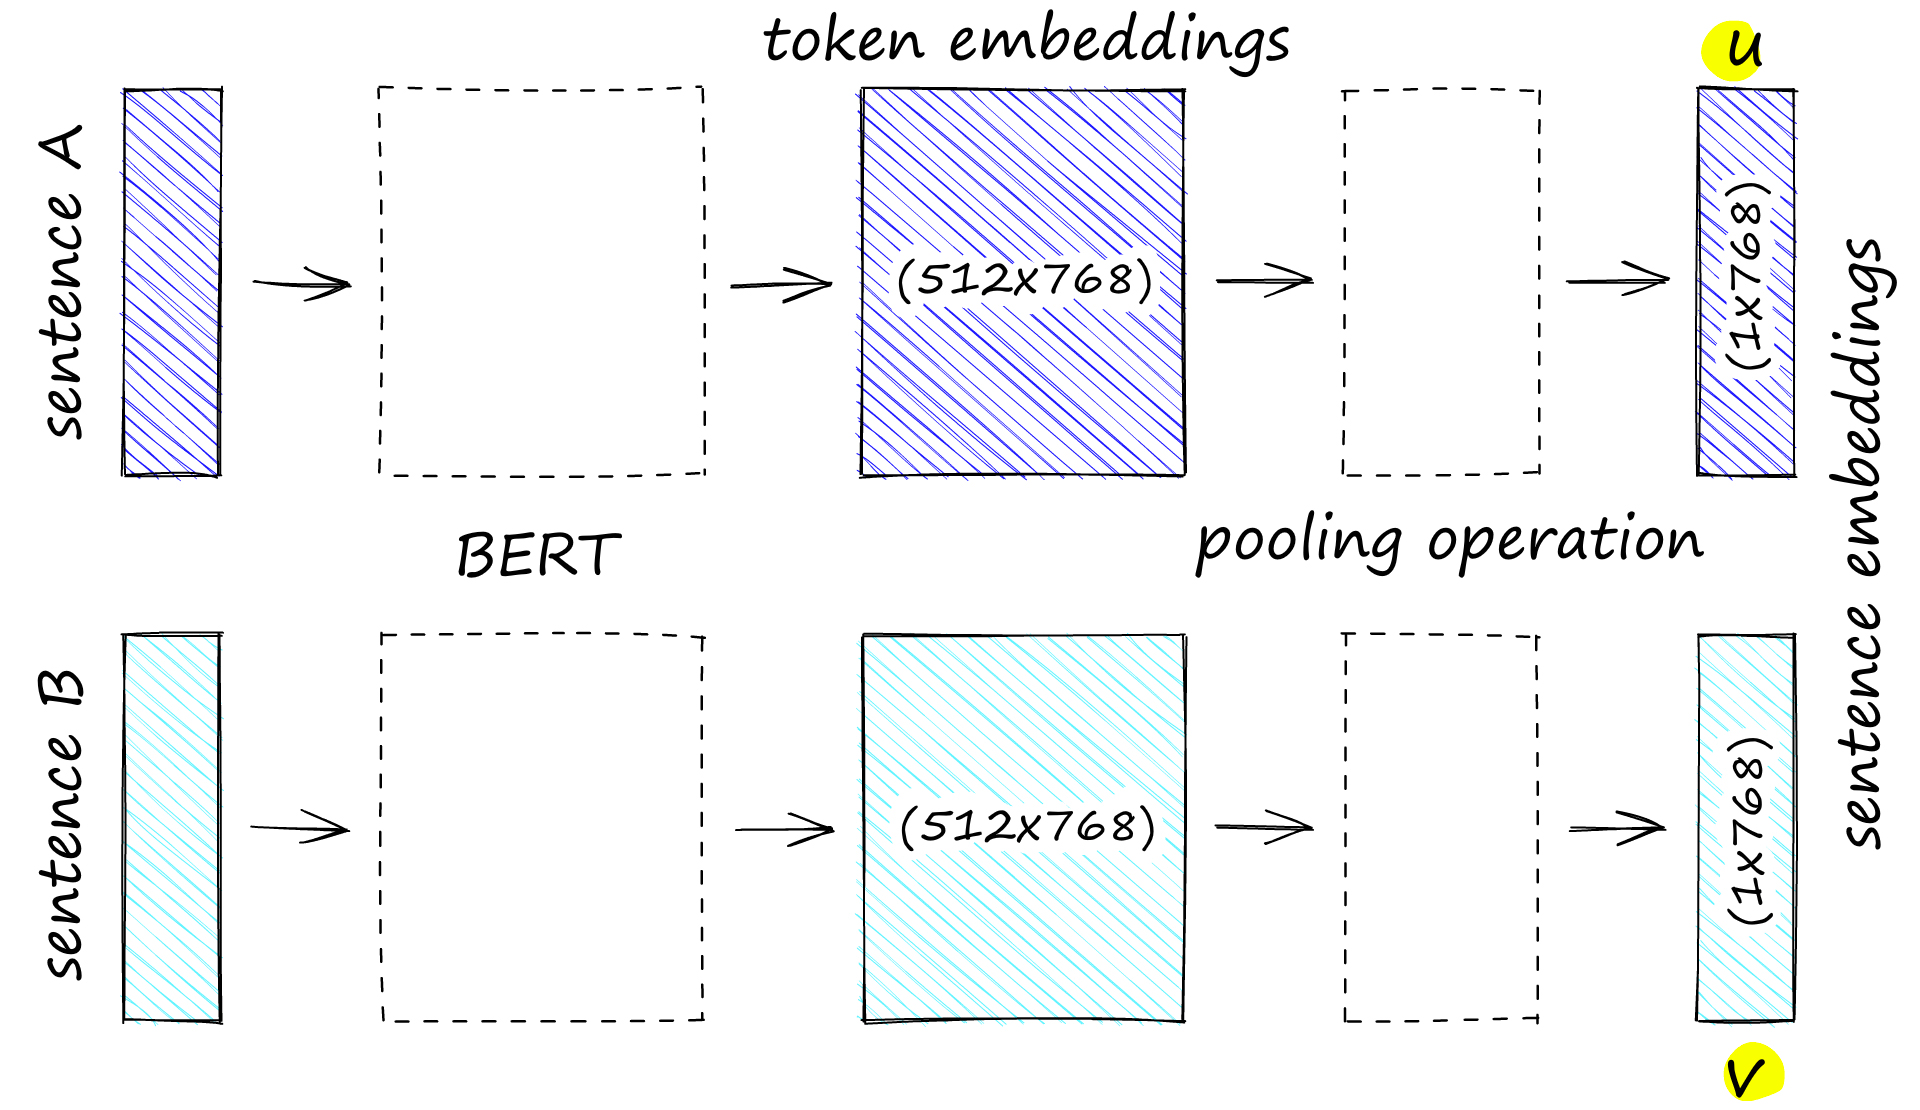

BERT will output 512 768-dimensional embeddings. We will convert these into an average embedding using mean-pooling. This pooled output is our sentence embedding. We will have two per step — one for sentence A that we call u, and one for sentence B, called v.

To perform this mean pooling operation, we will define a function called mean_pool.

In [14]:
def mean_pool(token_embeds, attention_mask):
    # reshape attention mask
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool

In [15]:
# Defining layers for classification
from torch.nn import Linear, CrossEntropyLoss

ffnn = Linear(768*3, 3)
loss_func = CrossEntropyLoss()

ffnn.to(device), loss_func.to(device)

(Linear(in_features=2304, out_features=3, bias=True), CrossEntropyLoss())

In [16]:
from transformers.optimization import get_linear_schedule_with_warmup
from torch.optim import AdamW

# Initialize everything first
optim = AdamW(model.parameters(), lr=1e-5)
epochs = 1

# Setup a warmup for the first ~10% steps
total_steps = int(len(dataset) / batch_size)
warmup_steps = int(0.1 * total_steps * epochs)
scheduler = get_linear_schedule_with_warmup(
	optim, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

In [17]:
from tqdm.auto import tqdm

# 1 epoch should be enough, increase if wanted
for epoch in range(1):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)

    total_loss = 0
    total_accuracy = 0

    for batch in loop:
        # zero all gradients on each new step
        optim.zero_grad()

        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['label'].to(device)

        # extract token embeddings from BERT
        u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A
        v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B
        
        # get the mean pooled vectors
        u = mean_pool(u, attention_a)
        v = mean_pool(v, attention_b)
        
        # build the |u-v| tensor
        uv = torch.sub(u, v)
        uv_abs = torch.abs(uv)
        
        # concatenate u, v, |u-v|
        x = torch.cat([u, v, uv_abs], dim=-1)
        
        # process concatenated tensor through FFNN
        x = ffnn(x)
        
        # calculate the 'softmax-loss' between predicted and true label
        loss = loss_func(x, label)
        
        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        
        # update learning rate scheduler
        scheduler.step()
        
        # Calculate accuracy
        preds = torch.argmax(x, dim=1)
        accuracy = (preds == label).float().mean()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

        # Update the tqdm progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item(), accuracy=accuracy.item())
    
    # Log average loss and accuracy to wandb
    wandb.log({"loss": total_loss / len(loader), "accuracy": total_accuracy / len(loader)})

wandb.finish()

  0%|          | 0/58880 [00:00<?, ?it/s]

accuracy,▁
loss,▁
accuracy,0.70632
loss,0.68285


In [19]:
model.save_pretrained("nli-bert")